In [1]:
import os, sys, argparse
import numpy as np

# Main C3 objects
from c3.libraries import constants
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.optimizers.optimalcontrol import OptimalControl

#%matplotlib widget

from four_level_transmons.utilities import *
from four_level_transmons.plotting import *
from four_level_transmons.custom_envelopes import *
from four_level_transmons.DataOutput import DataOutput

2022-02-16 14:35:33.867085: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 14:35:33.867330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [3]:
def printSignal(exper: Experiment, qubit: chip.Qubit,
                gate: gates.Instruction, output: DataOutput):
    # generate signal
    signal = generateSignal(exper, gate, qubit)
    ts = signal["ts"].numpy()
    values = signal["values"].numpy()

    # save data
    peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
    print("peaks: ", np.sort(peakFrequencies))
    output.save([ts, values], "signal")

    # plot
    plotSignalAndSpectrum(ts, real=values, filename=output.createFileName("signal", "png"))
    plotSignalAndSpectrum(ts, real=values, filename=output.createFileName("signal_detail", "png"), spectralThreshold=5e-4)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    populations = calculatePopulation(exper, init, [gate.get_key()])
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population"))


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
                                filename=output.createFileName(name + "_phase"))
    plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
                                filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")
    printMatrix(U, labels, "propagator", output)


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]
    for name, values in outputs.items():
        filename = output.createFileName(directory + "/device_" + name, "svg")
        time = values["ts"].numpy()
        if name.startswith("LO"):
            #time = time[:100]
            re = values["inphase"].numpy()
            im = values["quadrature"].numpy()
            plotSignalAndSpectrum(time, real=re, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_real", "svg"))
            plotSignalAndSpectrum(time, real=im, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_imag", "svg"))
        elif "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=5e-4)
        else:
            signal = values["inphase"].numpy() ** 2 + values["quadrature"].numpy() ** 2
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=5e-4, filename=filename)


def optimise(output: DataOutput, qubit: chip.PhysicalComponent, exp: Experiment,
             algorithm, options, gate: gates.Instruction):
    # set up the optimiser
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_set,
        fid_subspace=[qubit.name],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=gate.name,
        fid_func_kwargs={
            "active_levels": 4
        }
    )
    exp.set_opt_gates([gate.get_key()])
    opt.set_exp(exp)

    # add the callback
    infidelities = []
    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)
    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities

In [4]:
# Initialise the qubits and drive lines
qubit_levels = 5
qubit_frequency = 5e9
anharmonicity = -300e6
t1 = 25e-6
t2star = 35e-6
qubit_temp = 50e-3
level_labels = ["$|0,0\\rangle$", "$|0,1\\rangle$", "$|1,0\\rangle$", "$|1,1\\rangle$", "leakage"]
output = DataOutput(output_dir, file_suffix='before')

qubit = createQubits([qubit_levels], [qubit_frequency], [anharmonicity], [t1],
                      [t2star], qubit_temp)[0]
drive = createDrives([qubit])[0]

2022-02-16 14:35:52.970373: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-16 14:35:52.973570: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 14:35:52.973666: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 14:35:52.973735: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-02-16 14:35:52.977015: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
# Create the model
model = Mdl([qubit], [drive])
model.set_lindbladian(False)
model.set_dressed(True)
model.set_FR(False)

energies = qubit.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
print("energies: ", energies)
transitions = np.array([energies[i + 1] - energies[i] for i in range(len(energies) - 1)])
print("transition frequencies: ", transitions)

energies:  [0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
transition frequencies:  [5.0e+09 4.7e+09 4.4e+09 4.1e+09]


In [6]:
# Create the generator
generator = createGenerator2LOs([drive], useDrag=True)

In [7]:
# Envelopes and carriers
t_final = 40e-9
sideband = 50e6
#carrier_freqs = [(transitions[0] + transitions[1]) / 2, (transitions[1] + transitions[2]) / 2]
carrier_freqs = [transitions[0], transitions[2]]
print(carrier_freqs)
#numPWCPieces = 20

pulse_t_final = 30e-9
pulse_sigmas = [5e-9, 5e-9]
pulse_amps = [0.001, 0.3]
pulse_deltas = [0, 0]
pulse_xy_angles = [0, 0]

envelopes = []
for i in range(0, len(carrier_freqs)):
    gaussian_envelope = createGaussianPulse(
        t_final=pulse_t_final,
        sigma=pulse_sigmas[i],
        amp=pulse_amps[i],
        #sideband=sideband,
        delta=pulse_deltas[i],
        xy_angle=pulse_xy_angles[i]
    )
    gaussian_envelope.name = f"envelope{i + 1}"
    envelopes.append(gaussian_envelope)

carriers = []
for i, f in enumerate(carrier_freqs):
    x = f + sideband
    carrier_parameters = {
        "freq": Qty(value=x, min_val=0.9 * x, max_val=1.1 * x, unit="Hz 2pi"),
        "framechange": Qty(value=0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
    }
    carriers.append(pulse.Carrier(
        name=f"carrier{i+1}",
        desc="Frequency of the local oscillator",
        params=carrier_parameters,
    ))

[5000000000.0, 4399999999.999994]


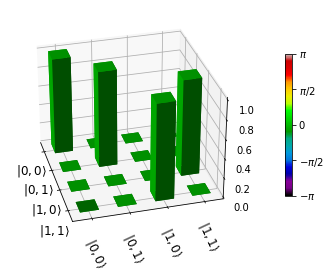

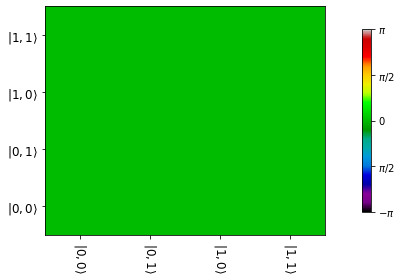

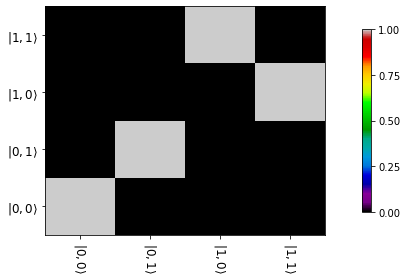

In [11]:
# Gate instructions
#ideal_gate = qt_utils.np_kron_n([constants.Id, constants.x90p])
ideal_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
printMatrix(ideal_gate, level_labels[:4], "ideal_gate", output)

gate = gates.Instruction(
    name="cnot12",
    targets=[0],
    t_start=0.0,
    t_end=t_final,
    channels=[drive.name],
    ideal=ideal_gate,
)
for env in envelopes:
    gate.add_component(copy.deepcopy(env), drive.name)
for carrier in carriers:
    gate.add_component(copy.deepcopy(carrier), drive.name)

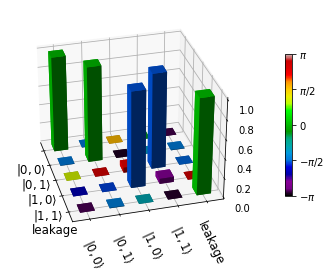

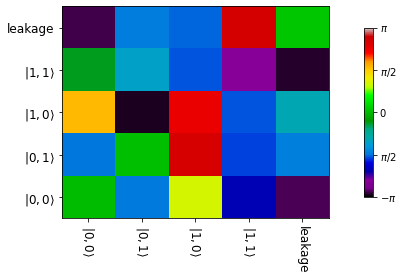

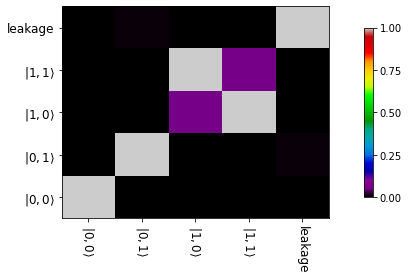

peaks:  [2.37529691e+09 4.40055007e+09 5.00062508e+09 6.37579697e+09]


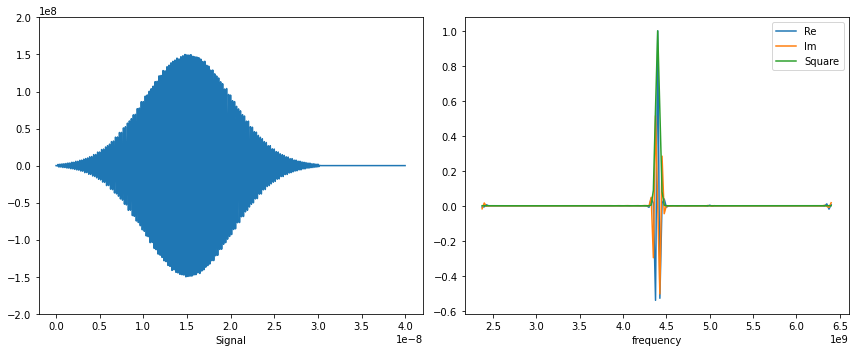

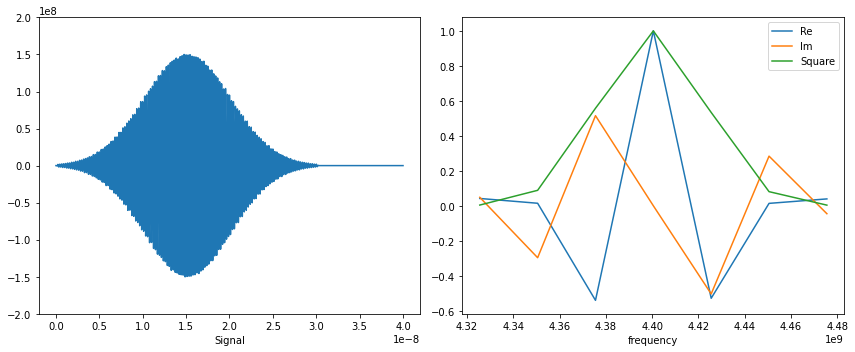

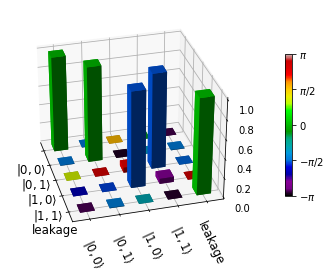

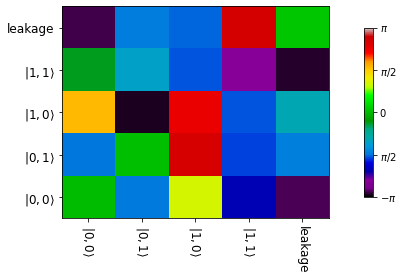

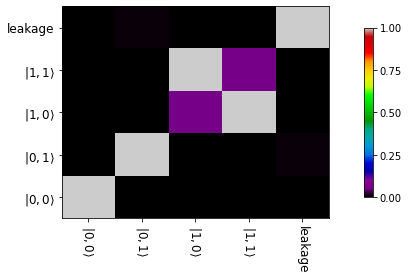

In [12]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates([gate.get_key()])

printSignal(exp, qubit, gate, output=output)

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels, output)

#printAllSignals(exp, qubit, output, directory="devices_before")

In [13]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

printTimeEvolution(exp, init_state, gate, level_labels, output)

In [14]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for env in [envelopes[1]]:
    opt_map.append([(gate.get_key(), "d1", env.name, "amp")])
    opt_map.append([(gate.get_key(), "d1", env.name, "sigma")])
    opt_map.append([(gate.get_key(), "d1", env.name, "freq_offset")])
    opt_map.append([(gate.get_key(), "d1", env.name, "xy_angle")])
    opt_map.append([(gate.get_key(), "d1", env.name, "delta")])
    opt_map.append([(gate.get_key(), "d1", env.name, "t_final")])
for carrier in [carriers[1]]:
    opt_map.append([(gate.get_key(), "d1", carriers[0].name, "freq")])
    opt_map.append([(gate.get_key(), "d1", carriers[0].name, "framechange")])
    opt_map.append([(gate.get_key(), "d1", carriers[1].name, "freq")])
    opt_map.append([(gate.get_key(), "d1", carriers[1].name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

cnot12[0]-d1-envelope2-amp            : 300.000 mV 
cnot12[0]-d1-envelope2-sigma          : 5.000 ns 
cnot12[0]-d1-envelope2-freq_offset    : -50.500 MHz 2pi 
cnot12[0]-d1-envelope2-xy_angle       : 0.000 rad 
cnot12[0]-d1-envelope2-delta          : 0.000  
cnot12[0]-d1-carrier1-freq            : 5.050 GHz 2pi 
cnot12[0]-d1-carrier1-framechange     : 0.000 rad 
cnot12[0]-d1-carrier2-freq            : 4.450 GHz 2pi 
cnot12[0]-d1-carrier2-framechange     : 0.000 rad 



In [15]:
infidelities = optimise(output, qubit, exp, algorithms.lbfgs, {"maxfun": 1000, "ftol": 1e-6}, gate)
#infidelities = optimise(output, qubit, exp, algorithms.cmaes, {"popsize": 12, "spread": 0.05}, gate)

C3:STATUS:Saving as: /home/user/c3/output/cnot12/2022_02_16_T_14_36_59/open_loop.c3log
1 0.539182031536299


/home/user/c3/c3/optimizers/optimizer.py:289: Warning: cnot12[0]-d1-carrier1-framechange has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
/home/user/c3/c3/optimizers/optimizer.py:289: Warning: cnot12[0]-d1-carrier2-framechange has no gradient. This might indicate no usage for current experiment.
  warnings.warn(


2 0.49677720514787593
3 0.5003443508480783
0.49677720514787593
cnot12[0]-d1-envelope2-amp            : 178.446 mV 
cnot12[0]-d1-envelope2-sigma          : 2.823 ns 
cnot12[0]-d1-envelope2-freq_offset    : -50.495 MHz 2pi 
cnot12[0]-d1-envelope2-xy_angle       : 91.246 mrad 
cnot12[0]-d1-envelope2-delta          : 10.211 m 
cnot12[0]-d1-carrier1-freq            : 5.050 GHz 2pi 
cnot12[0]-d1-carrier1-framechange     : 0.000 rad 
cnot12[0]-d1-carrier2-freq            : 4.484 GHz 2pi 
cnot12[0]-d1-carrier2-framechange     : 0.000 rad 



rx90p_q1[0]-d1-envelope1-amp          : 5.000 V 
rx90p_q1[0]-d1-envelope1-sigma        : 7.500 ns 
rx90p_q1[0]-d1-envelope1-freq_offset  : -50.500 MHz 2pi 
rx90p_q1[0]-d1-envelope1-xy_angle     : 0.000 rad 
rx90p_q1[0]-d1-envelope1-delta        : -1.000  
rx90p_q1[0]-d1-envelope2-amp          : 5.000 V 
rx90p_q1[0]-d1-envelope2-sigma        : 7.500 ns 
rx90p_q1[0]-d1-envelope2-freq_offset  : -50.500 MHz 2pi 
rx90p_q1[0]-d1-envelope2-xy_angle     : 0.000 rad 
rx90p_q1[0]-d1-envelope2-delta        : -1.000  
rx90p_q1[0]-d1-carrier1-freq          : 4.900 GHz 2pi 
rx90p_q1[0]-d1-carrier1-framechange   : 0.000 rad 
rx90p_q1[0]-d1-carrier2-freq          : 4.500 GHz 2pi 
rx90p_q1[0]-d1-carrier2-framechange   : 0.000 rad 
rx90p_q1[0]-d1-carrier1-freq          : 4.900 GHz 2pi 
rx90p_q1[0]-d1-carrier1-framechange   : 0.000 rad 
rx90p_q1[0]-d1-carrier2-freq          : 4.500 GHz 2pi 
rx90p_q1[0]-d1-carrier2-framechange   : 0.000 rad 



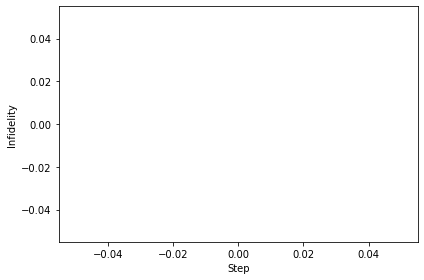

peaks:  [4.43407235e+09 4.83413902e+09 6.40106684e+09 6.80113352e+09]


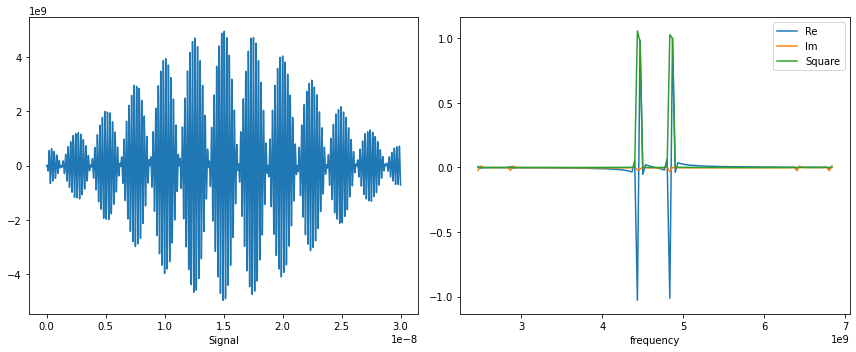

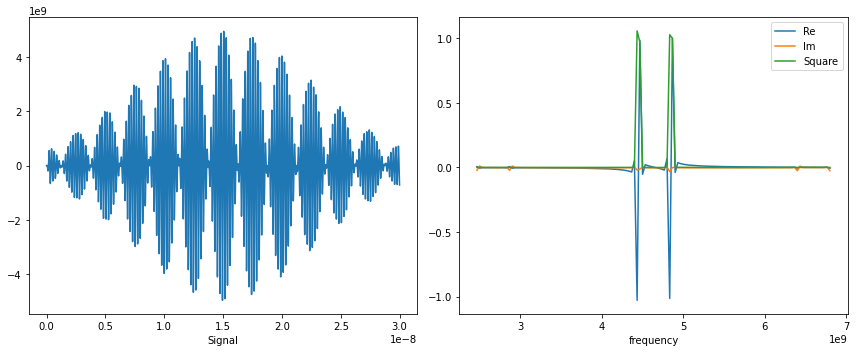

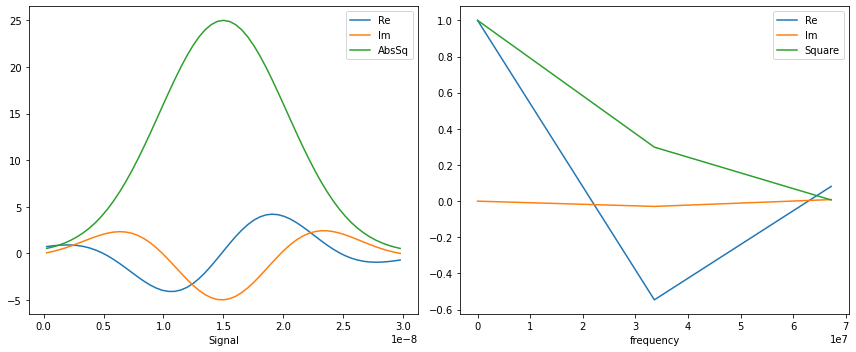

AWG2 peaks:  []


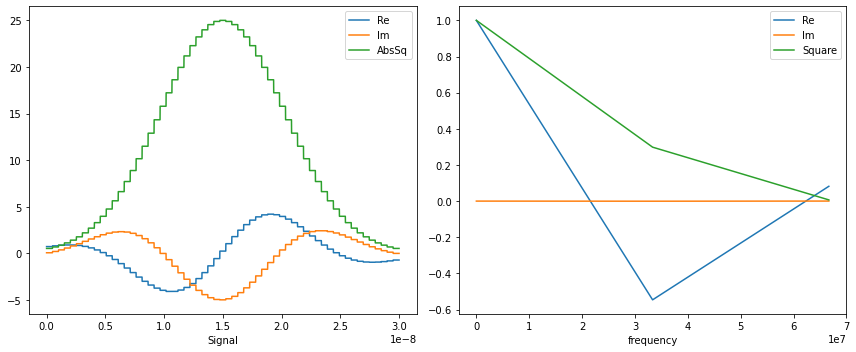

DigitalToAnalog2 peaks:  [1.93365561e+09 2.00033339e+09 3.90065011e+09 3.96732789e+09]


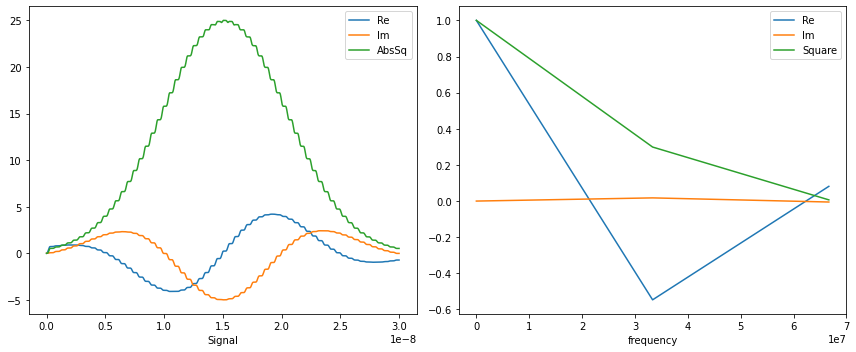

Response2 peaks:  [3.00050008e+08 1.93365561e+09 2.00033339e+09 3.90065011e+09]


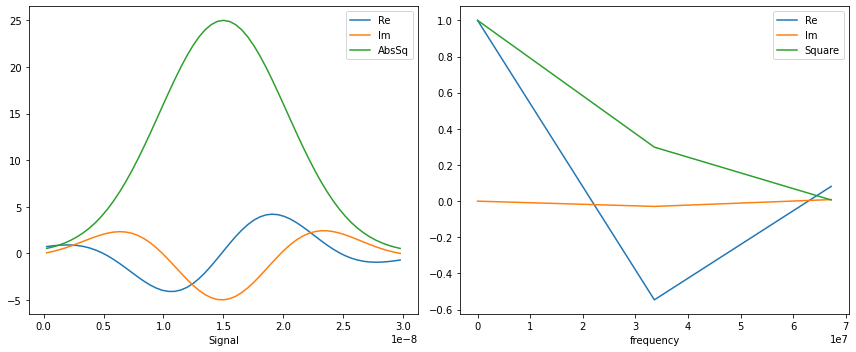

AWG1 peaks:  []


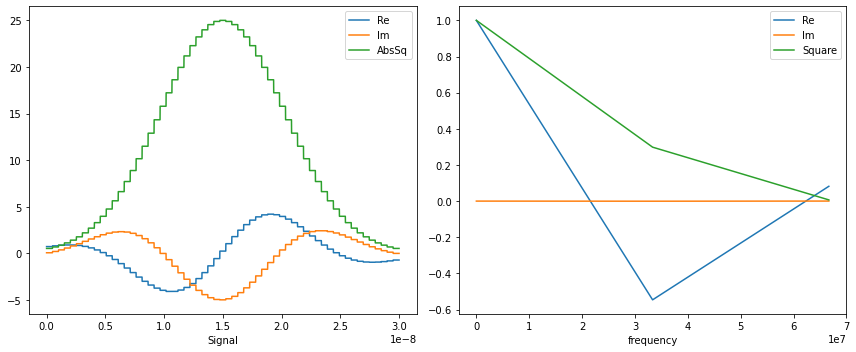

DigitalToAnalog1 peaks:  [1.93365561e+09 2.00033339e+09 3.90065011e+09 3.96732789e+09]


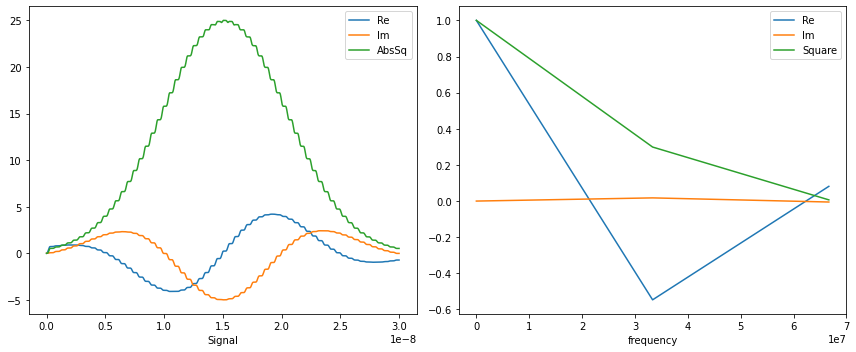

Response1 peaks:  [3.00050008e+08 1.93365561e+09 2.00033339e+09 3.90065011e+09]


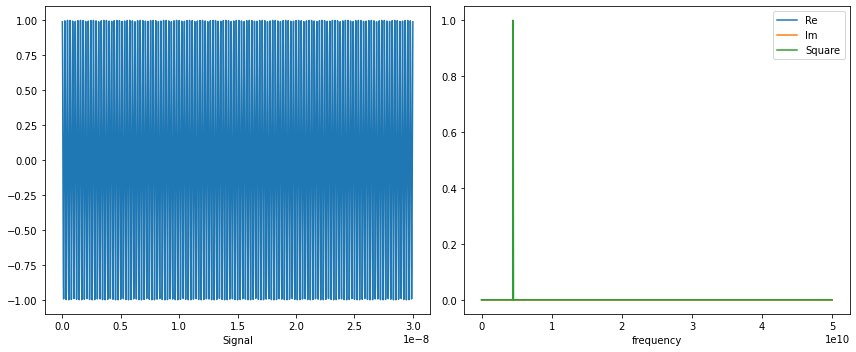

LO2 peaks:  [4.50075013e+09]


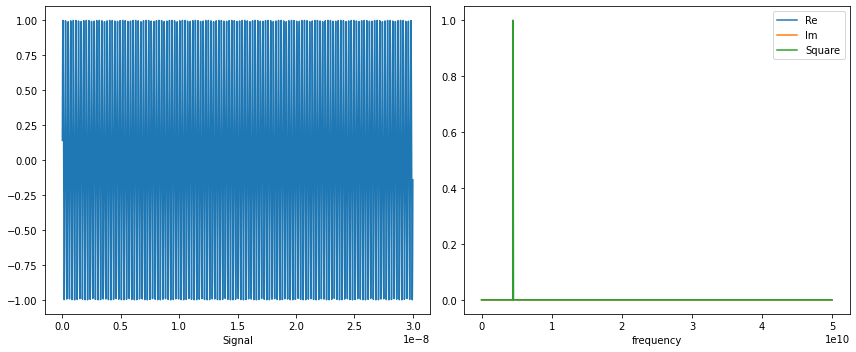

LO2 peaks:  [4.50075013e+09]


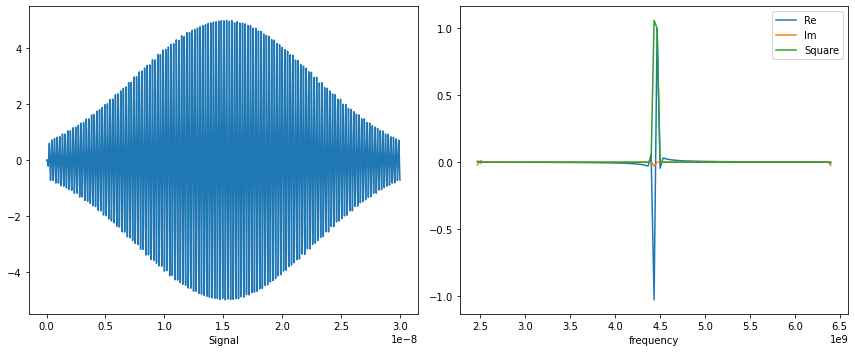

Mixer2 peaks:  [2.46707785e+09 4.43407235e+09 4.80080013e+09 6.40106684e+09]


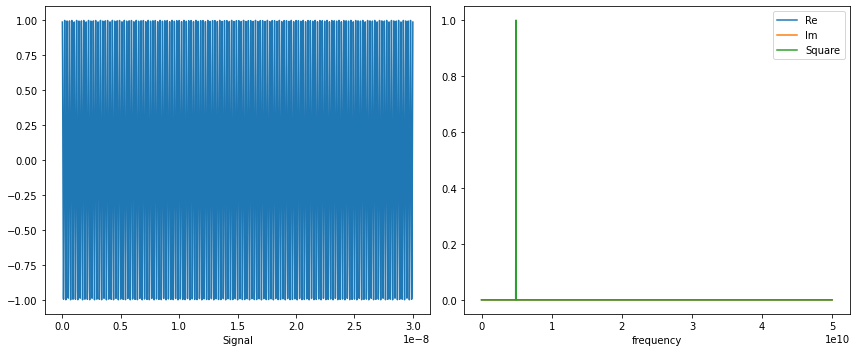

LO1 peaks:  [4.9008168e+09]


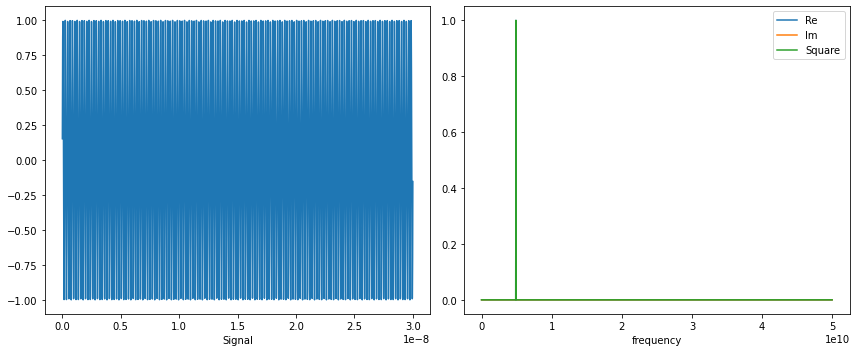

LO1 peaks:  [4.9008168e+09]


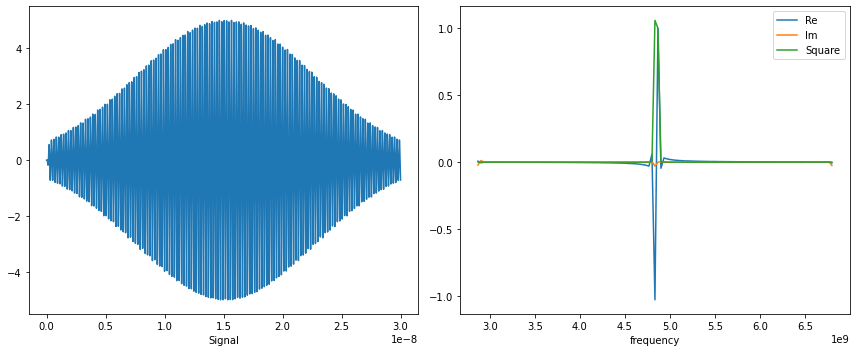

Mixer1 peaks:  [2.86714452e+09 4.83413902e+09 5.20086681e+09 6.80113352e+09]


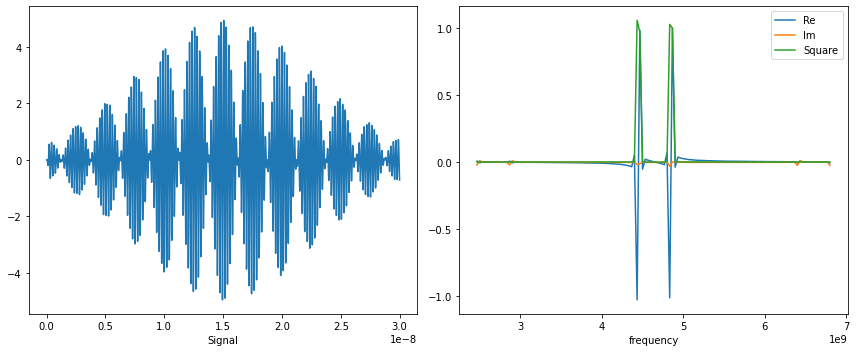

RealMixer peaks:  [4.43407235e+09 4.83413902e+09 6.40106684e+09 6.80113352e+09]


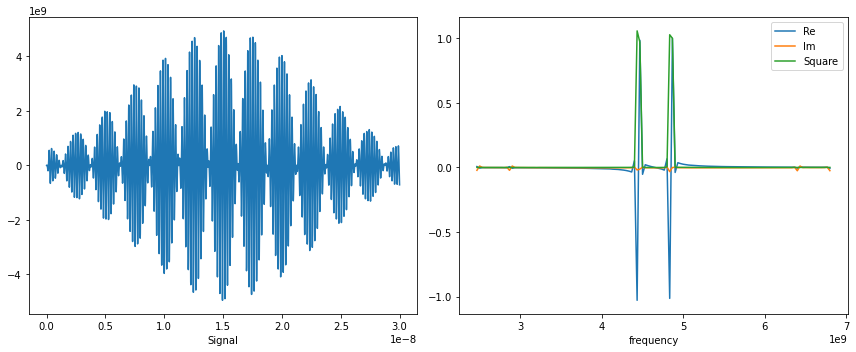

VoltsToHertz peaks:  [4.43407235e+09 4.83413902e+09 6.40106684e+09 6.80113352e+09]


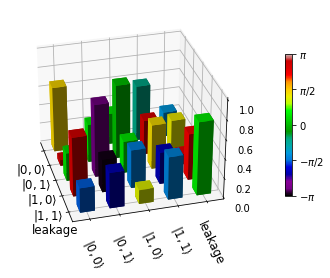

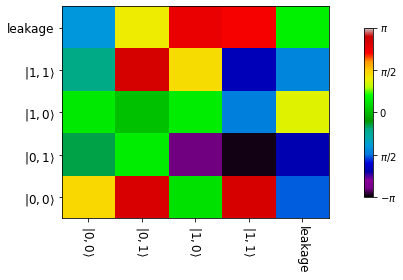

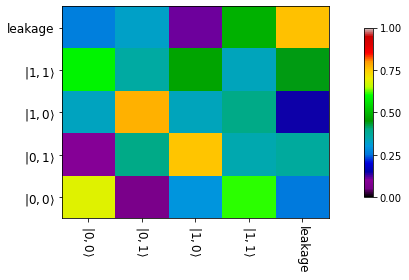

In [16]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "png"))
printSignal(exp, qubit, gate, output=output)
printAllSignals(exp, qubit, output, directory="devices_after")
printPropagator(exp, gate, level_labels, output)
printTimeEvolution(exp, init_state, gate, level_labels, output)